# Cassava Leaf Disease Classification
https://www.kaggle.com/competitions/cassava-leaf-disease-classification/overview
notebook 竞赛

## 浏览数据
1.train.csv
2.测试集
3.训练集

In [23]:
import pandas as pd

train_csv_path = '../input/cassava-leaf-disease-classification/train.csv'
df_train = pd.read_csv(train_csv_path)
print(df_train.head())
print(df_train.shape[0], ' ', df_train.shape[1])
print(len(df_train.iloc[:, 1].unique()))

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
21397   2
5


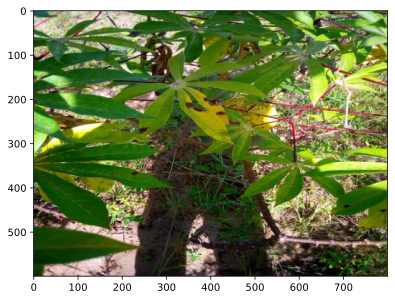

In [24]:
from PIL import Image
import os
import matplotlib.pyplot as plt

train_image_path = '../input/cassava-leaf-disease-classification/train_images/'
test_image_path = '../input/cassava-leaf-disease-classification/test_images/'
img = Image.open(os.path.join(train_image_path, df_train.iloc[0, 0]))
plt.imshow(img)

## 计算数据集的均值和方差

In [25]:
import numpy as np
import torch
import torchvision
mean = torch.zeros(3)
std = torch.zeros(3)

images = np.asarray([image for image in os.listdir(test_image_path)])
for single_image_name in images:
    for d in range(3):
        image_for_test = Image.open(os.path.join(test_image_path, single_image_name))
        trans = torchvision.transforms.ToTensor()
        tensor_for_test = trans(image_for_test)
        tensor_for_test = tensor_for_test.unsqueeze(0)
        mean[d] += tensor_for_test[:, d, :, :].mean()
        std[d] += tensor_for_test[:, d, :, :].std()
mean.div_(len(images))
std.div_(len(images))
mean = mean.numpy()
std = std.numpy()
print('mean:', mean, 'std:', std)

mean: [0.48118702 0.5207646  0.41442972] std: [0.24474435 0.25411636 0.22652327]


## 构建数据集

In [26]:
from torch.utils.data import Dataset

class MyCassavaLeafDataset(Dataset):
    @staticmethod
    def generate_index(num_total, ratio):
        all_index = [i for i in range(num_total)]
        k = ratio * 10
        valid_index = np.arange(0, num_total, k)
        train_index = [i for i in all_index if i not in valid_index]
        return train_index, valid_index

    def __init__(self, csv_path=None, images_path=None, transform=None, mode='train', train_ratio=0.5):
        super().__init__()
        self.transform = transform
        self.mode = mode
        self.images_path = images_path
        self.data_info = pd.read_csv(csv_path)
        self.data_len = self.data_info.shape[0]
        if self.mode == 'train':
            train_index, _ = MyCassavaLeafDataset.generate_index(self.data_len, train_ratio)
            self.image_arr = np.asarray(self.data_info.iloc[train_index, 0])
            self.label_arr = np.asarray(self.data_info.iloc[train_index, 1])
            self.real_len = len(self.image_arr)
        elif self.mode == 'valid':
            _, valid_index = MyCassavaLeafDataset.generate_index(self.data_len, train_ratio)
            self.image_arr = np.asarray(self.data_info.iloc[valid_index, 0])
            self.label_arr = np.asarray(self.data_info.iloc[valid_index, 1])
            self.real_len = len(self.image_arr)

    def __getitem__(self, index):
        if self.mode != 'test':
            single_image_name = self.image_arr[index]
            image = Image.open(os.path.join(self.images_path, single_image_name))
            image = np.array(image)
            label = self.label_arr[index]
            return self.transform(image=image)["image"], label


    def __len__(self):
        return self.real_len

## 图像增广

In [27]:
import torchvision
import albumentations as alb
from albumentations.pytorch import ToTensorV2
normalize = alb.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_augs = alb.Compose([
    alb.RandomResizedCrop(224, 224), # 对图像进行随机的裁剪，最后resize到224*224
    alb.Transpose(p=0.5),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.ShiftScaleRotate(p=0.5),
    normalize,
    ToTensorV2()# 图片是png格式的，要转换为tensor
])

valid_augs = alb.Compose([
    alb.Resize(224, 224),
    normalize,
    ToTensorV2()
])

## 生成训练和验证数据集与迭代器

In [28]:
# train_set = MyCassavaLeafDataset(csv_path=train_csv_path, images_path=train_image_path, transform=train_augs, mode='train')
# train_iter = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
# valid_set = MyCassavaLeafDataset(csv_path=train_csv_path, images_path=train_image_path, transform=valid_augs, mode='valid')
# valid_iter = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)

## 搭建训练模型
EfficientNetB4

In [29]:
net = torchvision.models.efficientnet_b4()
net

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## 定义训练函数

In [30]:
import torch
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
from IPython import display
import time
from torch import nn
import torchvision

# 使用svg格式来展示图片
def use_svg_display():
    return backend_inline.set_matplotlib_formats("svg")


# 累加器类型
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, item):
        return self.data[item]


# 用于设置坐标轴
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


# 展示正确率、错误率随训练轮数改变的曲线 这是一个动画类型！！！
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None,
                 xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]  # 转换为列表用以统一数据结构
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim,
                                            xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):  # x,y包含多个数据点
        if not hasattr(y, '__len__'):  # 判断y是否是一个可迭代类型（list等）
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):  # 将要绘制的点的集合传入类中
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()  # 清除该图上之前的内容，每次传进来的(x,y)是全体的，每一轮绘制从头绘制到最后一个点
        for x, y, fmts in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmts)  # 画图过程
        self.config_axes()  # 配置axe的相关参数
        display.display(self.fig)  # 显示绘制的图片
        display.clear_output(wait=True)  # 清除notebook中的输出内容


# 用于计数预测对的数量（多分类）
def count_accurate(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    correct_count = 0
    for i in range(len(y_hat)):
        if y_hat[i].type(y.dtype) == y[i]:
            correct_count += 1
    return float(correct_count)


# 查询机器上所有可用的GPU
def try_all_gpu():
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else torch.device('cpu')


# 记录多任务训练时间
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return (sum(self.times)) / (len(self.times))

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()


# GPU计算准确率
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(count_accurate(net(X), y), y.numel())
    return metric[0] / metric[1]


# 多GPU mini-batch训练函数
def train_batch_gpus(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()  # 表示模型进入训练模式
    trainer.zero_grad()  # 梯度清零
    pred = net(X)  # 计算y_hat
    l = loss(pred, y)  # 计算损失
    l.sum().backward()  # 对损失求梯度
    trainer.step()  # 用梯度更新模型参数
    train_loss = l.sum()
    train_acc_sum = count_accurate(pred, y)
    return train_loss, train_acc_sum


# 多GPU训练函数
def train_gpus(net, train_iter, test_iter, loss, trainer, num_epochs, devices=try_all_gpu()):
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0],
                        legend=['train_loss', 'train_acc', 'test_acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    best_test_acc = 0
    for epoch in range(num_epochs):
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_gpus(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            """
            如果是分类问题，一个样本只有一个标签，这种情况下labels.shape[0]和labels.numel()没有区别
            但是如果是多多标签分类问题，即一个样本有多个标签，那numel就会多于shape[0]
            """
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
                """
                计算平均损失率：总的损失/样本个数
                计算训练正确率：正确的预测标签个数/总的预测标签个数
                """
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        if test_acc > best_test_acc:
            torch.save(net.state_dict(), './pre_res_model.ckpt')
            best_test_acc = test_acc
    print(f'loss {metric[0] / metric[2]:.3f}, train_acc {metric[1] / metric[3]:.3f}, test_acc {test_acc:.3f}')
    print((f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on ', f'{str(devices)}'))


# 使用预训练参数进行训练的函数
def train_fine_tuning(net, train_iter, test_iter, trainer, num_epochs, learning_rate, model_path='./pre_res_model.ckpt',
                      param_group=True,
                      devices=try_all_gpu()):
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        param_1x = [param for name, param in net.named_parameters() if
                    name not in ['classifier.1.weight', 'classifier.1.bias']]  # net.named_parameters()返回每一层的变量名和变量的值
        trainer = trainer([{'params': param_1x},
                           {'params': net.classifier[-1].parameters(),
                            'lr': learning_rate * 10}],
                          lr=learning_rate, weight_decay=0.001)
    else:
        trainer = trainer(net.parameters(), lr=learning_rate, weight_decay=0.001)
    train_gpus(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [31]:
# net = torchvision.models.resnet18()
# net.fc = nn.Linear(net.fc.in_features, 5)
# nn.init.xavier_uniform_(net.fc.weight)
# trainer = torch.optim.Adam
# num_epochs, lr = 20, 5e-5
# train_fine_tuning(net, train_iter, valid_iter, trainer, num_epochs, lr)

In [32]:
torch.cuda.empty_cache()

## 正式训练并生成submission

loss 0.393, train_acc 0.862, test_acc 0.837
('102.9 examples/sec on ', "[device(type='cuda', index=0), device(type='cuda', index=1)]")


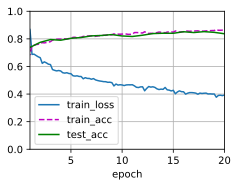

In [33]:
test_augs = alb.Compose([
    alb.Resize(224, 224),
    normalize,
    ToTensorV2()
])
train_set = MyCassavaLeafDataset(csv_path=train_csv_path, images_path=train_image_path, transform=train_augs, mode='train')
train_iter = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = MyCassavaLeafDataset(csv_path=train_csv_path, images_path=train_image_path, transform=valid_augs, mode='valid')
valid_iter = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
net = torchvision.models.efficientnet_b4(pretrained=True)
net.classifier[-1] = nn.Linear(net.classifier[-1].in_features, 5)
nn.init.xavier_uniform_(net.classifier[-1].weight)
trainer = torch.optim.Adam
num_epochs, lr = 20, 1e-4
train_fine_tuning(net, train_iter, valid_iter, trainer, num_epochs, lr)

In [42]:
net.eval()
net = torchvision.models.efficientnet_b4()
net.classifier = nn.Linear(net.classifier[-1].in_features, 5)
checkpoint = torch.load('./pre_res_model.ckpt')
new_state_dict = {k[7:]: v for k, v in checkpoint.items() if 'module.' in k}
fixed_state_dict = {}
for k, v in new_state_dict.items():
    if k == "classifier.1.weight":
        k = "classifier.weight"
    elif k == "classifier.1.bias":
        k = "classifier.bias"
    fixed_state_dict[k] = v
net.load_state_dict(fixed_state_dict)
preds = []
predictions = []

images = np.asarray([image for image in os.listdir(test_image_path)])
for single_image_name in images:
    with torch.no_grad():
        augmented_data = test_augs(image=np.array(Image.open(os.path.join(test_image_path, single_image_name))))
        image_for_test = augmented_data['image']
        ans = net(image_for_test.unsqueeze(0))
        ans = ans.argmax(dim=-1).numpy()
        preds.append(ans)


df_sub = pd.DataFrame(columns=df_train.columns)
df_sub['image_id'] = pd.DataFrame(images)
df_sub['label'] = pd.DataFrame(preds)
df_sub.to_csv('submission.csv', index=False)